In [1]:
#data management 
using CSV
using DataFrames
using PowerSystems
#datetime stuff
using TimeSeries
using Dates
##optimization
using JuMP
using Gurobi

### Setting up Generators

In [2]:
gen_data = DataFrame(CSV.File("data/gen_thermal_data_modified_margins.csv"))
node_name = ["BEL AIR", "CDB", "TP", "KP", "KAH", "MP", "CG", "KPS", "SENDOU", "OMVG"]
nodes_thermal = [ACBus(i, name, nothing, nothing, nothing, (min = 0.9, max = 1.05), nothing, nothing, nothing) for (i, name) in zip(1:length(node_name), node_name)]
#
thermal_generator = []
for g in eachrow(gen_data)
    node = nodes_thermal |> filter(x-> get_name(x) == g.Nom_Noeud ) |> first
    p = PrimeMovers.ST
    up_down = (up = 1, down = 1)
    if g.Fuel == "HTS"
        f = ThermalFuels.RESIDUAL_FUEL_OIL
    elseif g.Fuel == "BTS"
        f = ThermalFuels.DISTILLATE_FUEL_OIL
    elseif g.Fuel == "COAL"
        f = ThermalFuels.COAL
    elseif g.Fuel == "GAZ"
        f = ThermalFuels.NATURAL_GAS
    elseif g.Fuel == "HYDRO"
        f = ThermalFuels.OTHER
        P = PrimeMovers.HY
        up_down = (up = 0, down = 0)
    else
        println("a problem happened for $(g.CENTRALE)")
    end
    t = ThermalStandard(;
        name = g.CENTRALE, 
        available = true, 
        status = true,
        bus = node,
        active_power = 0,
        reactive_power = 0,
        rating = 100,
        prime_mover_type = p,
        fuel = f, 
        active_power_limits = (min = g.P_MIN, max = g.P_MAX), 
        reactive_power_limits = nothing,
        operation_cost = ThreePartCost(g.Cost, 0.0, 0.0, 0.0),
        base_power = g.Puissance_nominale_MVA, 
        ramp_limits = (up = g.RAMP_UP, down = g.RAMP_DOWN),
        time_limits = up_down
        )
    push!(thermal_generator, t)
end
print("done")

done

### Setting up Renewable Generators

In [3]:
renew_generator = []
gen_renew_data = DataFrame(CSV.File("data/gen_renew_data.csv"))
#
node_name = ["CICAD", "BOKHOL", "DIASS", "MALICOUNDA", "KAHONE", "TOUBA", "MERINA", "SANTHIOU", "SAKAL", "TAIBA NDIAYE"]
nodes_renew = [ACBus(i, name, nothing, nothing, nothing, (min = 0.9, max = 1.05), nothing, nothing, nothing) for (i, name) in zip(11:11+length(node_name), node_name)] #length of first node name is 10
#
for g in eachrow(gen_renew_data)
    node = nodes_renew |> filter(x-> get_name(x) == g.Nom_Noeud ) |> first
    if g.type == "PV"
        p = PrimeMovers.PVe
    else
        p = PrimeMovers.WT
    end
    r = RenewableDispatch(;
        name = g.CENTRALE,
        available = true,
        bus = node,
        active_power = 0, 
        reactive_power = 0,
        rating = g.rating,
        prime_mover_type = p,
        reactive_power_limits = (min = 0.0, max = 0.0),
        power_factor = 1.0,
        operation_cost = TwoPartCost(0.0, 0.0),
        base_power = 100)
    push!(renew_generator, r)
end
print("done")

done

### Adding a SLACK GEN

In [4]:
#slack_node = get_components(ACBus, system) |> collect |> filter(x -> get_name(x) == "BEL AIR") |> first 
slack_node = nodes_thermal |> filter(x-> get_name(x) == "BEL AIR" ) |> first
slack = ThermalStandard(;
    name = "SLACK", available = true, status = true, bus = slack_node, active_power = 0, reactive_power = 0, rating = 1E4,
    prime_mover_type = PrimeMovers.ST, fuel = ThermalFuels.RESIDUAL_FUEL_OIL, active_power_limits = (min = 0, max = 1E4), reactive_power_limits = nothing,
    operation_cost = ThreePartCost(1E6, 0.0, 0.0, 0.0), base_power = 100, ramp_limits = (up = 1E4, down = 1E4), time_limits = (up = 0, down = 0)
    )
push!(thermal_generator, slack);
print("done")

done

### Building the system

In [5]:
nodes = vcat(nodes_thermal, nodes_renew)
system = System(100.0, nodes, vcat(thermal_generator, renew_generator,));
set_units_base_system!(system, "DEVICE_BASE")
print("done")

┌ Error: Model doesn't contain a slack bus
└ @ PowerSystems C:\Users\lenovo\.julia\packages\PowerSystems\mjN6j\src\utils\IO\system_checks.jl:27
┌ Warning: Bus/Nodes data does not contain information to build an a network
└ @ PowerSystems C:\Users\lenovo\.julia\packages\PowerSystems\mjN6j\src\utils\IO\system_checks.jl:9
┌ Warning: Bus/Nodes data does not contain information to build an a network
└ @ PowerSystems C:\Users\lenovo\.julia\packages\PowerSystems\mjN6j\src\utils\IO\system_checks.jl:9
┌ Warning: Bus/Nodes data does not contain information to build an a network
└ @ PowerSystems C:\Users\lenovo\.julia\packages\PowerSystems\mjN6j\src\utils\IO\system_checks.jl:9
┌ Warning: Bus/Nodes data does not contain information to build an a network
└ @ PowerSystems C:\Users\lenovo\.julia\packages\PowerSystems\mjN6j\src\utils\IO\system_checks.jl:9
┌ Warning: Bus/Nodes data does not contain information to build an a network
└ @ PowerSystems C:\Users\lenovo\.julia\packages\PowerSystems\mjN6j\src

done

[ Info: Unit System changed to UnitSystem.DEVICE_BASE = 1


### Adding Time Series for renewable and extracting demand

In [6]:
#using CSV
#using DataFrames
using TimeSeries
file_path = "data/renew_1&2Dec_2023.csv"
renew_df = CSV.File(file_path) |> DataFrame
#
resolution = Dates.Hour(1)
dates = range(DateTime("2023-12-01T01:00:00"), step = resolution, DateTime("2023-12-2T23:00:00"))
for name in DataFrames.names(renew_df)[2:end]
    data = TimeArray(dates, renew_df[!, Symbol(name)])
    time_series = SingleTimeSeries("Renewable Evolution", data)
    add_time_series!(system, get_component(RenewableDispatch, system, name), time_series)
end
print("done")

done

### Extracting Demand

In [7]:
file_path = "data/demand_1&2Dec_2023.csv"
demand_df = CSV.File(file_path) |> DataFrame
#
demand = demand_df.Demand_in_MW;

### Setting Up Reserves

In [8]:
Pr = Dict("$(g.CENTRALE)" => (0) for g in eachrow(gen_data))# Pr for primary res
Sr = Dict("$(g.CENTRALE)" => (0) for g in eachrow(gen_data))# Sr for secondary res
Tr = Dict("$(g.CENTRALE)" => (1) for g in eachrow(gen_data))# Tr for tertiary res
# if can deliver at least half the margin of your power in less than 20 min, you are eligible for 3rd res
generators = get_components(ThermalStandard, system)
for g in generators
    if(20 * get_ramp_limits(g).up >= (get_active_power_limits(g).max-get_active_power_limits(g).min)/2) && get_name(g) != "SLACK"
        Tr["$(get_name(g))"] = 1
    else
        Tr["$(get_name(g))"] = 0
    end
end
# if can deliver at least half the margin of your power in less than 5 min, you are eligible for 2nd res (given you have AGC)
for g in generators
    if(5 * get_ramp_limits(g).up >= (get_active_power_limits(g).max-get_active_power_limits(g).min)/2) && get_name(g) != "SLACK"
        Sr["$(get_name(g))"] = 1
    else
        Sr["$(get_name(g))"] = 0
    end
end
#given the data I have, if you can deliver primary res, you can also deliver 2nd and 3rd res
for g in eachrow(gen_data)
    Pr["$(g.CENTRALE)"] = g.REG
end 
Pr["SLACK"] = 0 #slack is not in gen_data and it should surely not provide prim res
#solve slack issue, it should not provide reserve

0

### UC

In [9]:
mutable struct ValueInitializer
    pg_init::Float64
    u_init::Int64
end
mutable struct Reserve
    pr::Float64
    sr::Float64
    tr::Float64
    
end
Ɣ2_cost = 1E4
Ɣ3_cost = 1E4

10000.0

In [27]:
softlimit = 5
hardlimit = 300
function my_callback_function(cb_data, cb_where::Cint)
    if cb_where == GRB_CB_MIP
        runtimeP = Ref{Cdouble}()
        objbstP = Ref{Cdouble}()
        objbndP = Ref{Cdouble}()
        GRBcbget(cb_data, cb_where, GRB_CB_RUNTIME, runtimeP)
        GRBcbget(cb_data, cb_where, GRB_CB_MIP_OBJBST, objbstP)
        GRBcbget(cb_data, cb_where, GRB_CB_MIP_OBJBND, objbndP)
        gap = abs((objbstP[] - objbndP[]) / objbstP[])
        println("The current gap is : $(gap)")
        if runtimeP[] > hardlimit && gap < 0.5
            GRBterminate(backend(uc_model))
        end
    end
    return
end

my_callback_function (generic function with 1 method)

In [78]:
function uc_model(system::System, target_date::DateTime, init::ValueInitializer, Reserve, optimizer)
    uc_m = Model(optimizer)
    #callbacks to print logs
    MOI.set(uc_m, Gurobi.CallbackFunction(), my_callback_function)
    #
    # Set the MIP gap to 0.01 (1%)
    set_optimizer_attribute(uc_m, "MIPGap", 0.01)
    #
    set_silent(uc_m)
    time_periods = 1:47
    N = length(get_components(ThermalStandard, system))
    thermal_gen_names = get_name.(get_components(ThermalStandard, system))
    @variable(uc_m, pg[g in thermal_gen_names, t in time_periods] >= 0)
    #reserve vars
    @variable(uc_m, r1[g in thermal_gen_names, t in time_periods] >= 0)
    @variable(uc_m, r2[g in thermal_gen_names, t in time_periods] >= 0)
    @variable(uc_m, r3s[g in thermal_gen_names, t in time_periods] >= 0)
    @variable(uc_m, r3ns[g in thermal_gen_names, t in time_periods] >= 0)
    #vars for violation of reserve vals
    #@variable(uc_m, Reserve.pr >= Ɣ1[t in time_periods] >= 0)
    @variable(uc_m, Reserve.sr >= Ɣ2[t in time_periods] >= 0)
    @variable(uc_m, Reserve.tr >= Ɣ3[t in time_periods] >= 0)
    #binary vars
    @variable(uc_m, u[g in thermal_gen_names, t in time_periods], Bin)
    @variable(uc_m, su[g in thermal_gen_names, t in time_periods], Bin)
    @variable(uc_m, sd[g in thermal_gen_names, t in time_periods], Bin)
    ##
    @variable(uc_m, svu[g in thermal_gen_names, t in time_periods], Bin)
    @variable(uc_m, svd[g in thermal_gen_names, t in time_periods], Bin)
    @variable(uc_m, v[g in thermal_gen_names, t in time_periods], Bin)
    ##

    for g in get_components(ThermalStandard, system), t in time_periods
        name = get_name(g)
        if t == 1
            @constraint(uc_m, pg[name, t]-init.pg_init <= min(60*get_ramp_limits(g).up, get_active_power_limits(g).max))#i multiply by 60 bcz the ramps were expressed in mw/min and i didn't wan't to change the da
            @constraint(uc_m, init.pg_init-pg[name, t] <= min(60*get_ramp_limits(g).down, get_active_power_limits(g).max))
            @constraint(uc_m, init.u_init - u[name, t] + su[name, t] - sd[name, t] == 0 )
            ##~~~~~
            @constraint(uc_m, init.u_init - v[name, t] + svu[name, t] - svd[name, t] == 0 )
            ##~~~~~
        else
            @constraint(uc_m, u[name, t-1] - u[name, t] + su[name, t] - sd[name, t] == 0 )
            ##~~~~~
            @constraint(uc_m, v[name, t-1] - v[name, t] + svu[name, t] - svd[name, t] == 0 )
            ##~~~~~
            @constraint(uc_m, pg[name, t]-pg[name, t-1] <= min(60*get_ramp_limits(g).up, get_active_power_limits(g).max))
            @constraint(uc_m, pg[name, t-1]-pg[name, t] <= min(60*get_ramp_limits(g).down, get_active_power_limits(g).max))
            
            # MinUpTime
            if t <= get_time_limits(g).up
                @constraint(uc_m, sum(su[name, trunc(Int, i)] for i in t-1:-1:1) <= u[name, t] )
            else
                @constraint(uc_m, sum(su[name, trunc(Int, i)] for i in (t-1):-1:(t-get_time_limits(g).up+1)) <= u[name, t] )
            end
            # MinDownTime
            if t <= get_time_limits(g).down
                @constraint(uc_m, sum(sd[name, trunc(Int, i)] for i in t-1:-1:1) <= 1 - u[name, t] )
            else
                @constraint(uc_m, sum(sd[name, trunc(Int, i)] for i in (t-1):-1:(t-get_time_limits(g).up+1)) <= 1 - u[name, t] )
            end 
            
            ##~~~~~
            # MinUpTime hot state
            if t <= 5*get_time_limits(g).up #uptime 1H but it must be down for 5 hours bcz that time corresponds to the time needed to heat the boiler
                @constraint(uc_m, sum(svu[name, trunc(Int, i)] for i in t-1:-1:1) <= v[name, t] )
            else
                @constraint(uc_m, sum(svu[name, trunc(Int, i)] for i in (t-1):-1:(t-5*get_time_limits(g).up+1)) <= v[name, t] )
            end
            # MinDownTime hot state
            if t <= 5*get_time_limits(g).down
                @constraint(uc_m, sum(svd[name, trunc(Int, i)] for i in t-1:-1:1) <= 1 - v[name, t] )
            else
                @constraint(uc_m, sum(svd[name, trunc(Int, i)] for i in (t-1):-1:(t-5*get_time_limits(g).up+1)) <= 1 - v[name, t] )
            end 
            ##~~~~~
            
        end
        ##~~~~~
        @constraint(uc_m, svu[name, t] + svd[name, t] <= 1 )        
        ##~~~~~
        @constraint(uc_m, su[name, t] + sd[name, t] <= 1 )
        #power generation + reserve
        @constraint(uc_m, pg[name, t] >= get_active_power_limits(g).min*u[name, t] ) 
        @constraint(uc_m, pg[name, t] +r1[name, t]+ r2[name, t]+ r3s[name, t] <= get_active_power_limits(g).max*u[name, t] )
        #limit values for reserves
        @constraint(uc_m, r1[name, t] <= 0.5*Pr[name]*u[name, t]*get_ramp_limits(g).up) 
        @constraint(uc_m, r2[name, t] <= u[name, t]*Sr[name]*min(5*get_ramp_limits(g).up, trunc(Int, get_active_power_limits(g).max)) ) #forced to use trunc bcz sometimes Gmax 
        @constraint(uc_m, r3s[name, t] <= u[name, t]*Tr[name]*min(20*get_ramp_limits(g).up, trunc(Int, get_active_power_limits(g).max)) ) #results can generate float and solver can not
        @constraint(uc_m, r3ns[name, t] <= v[name, t]*min(20*get_ramp_limits(g).up, trunc(Int, get_active_power_limits(g).max)) )          # handle <= Type{Float64}
        #tertiary reserve related constraint
        @constraint(uc_m, v[name, t] <= Tr[name])
        @constraint(uc_m, v[name, t] + u[name, t] <= 1)
    end
    #partial reserve must be equal
    for t in time_periods
        @constraint(uc_m, sum(r1[name, t] for name in thermal_gen_names) == Reserve.pr)
        @constraint(uc_m, sum(r2[name, t] for name in thermal_gen_names) == Reserve.sr - Ɣ2[t])
        @constraint(uc_m, sum(r3s[name, t]+r3ns[name, t] for name in thermal_gen_names) == Reserve.tr - Ɣ3[t])
    end
    ###Load Gen Equality Constr
    net_load = zeros(length(time_periods))
    println(target_date)
    for g in get_components(RenewableGen, system)
        net_load -= get_time_series_values(SingleTimeSeries, g, "Renewable Evolution", start_time = target_date, len = 47,)
    end

    net_load += demand[1:end]#only works here because I know the format of the data (first day of month )

    for t in time_periods
        @constraint(uc_m, sum(pg[g, t] for g in thermal_gen_names) == net_load[t])
    end
    ###Load Gen Equality Constr
    @objective(uc_m, Min, sum(
            (pg[get_name(g), t])*(get_fixed(get_operation_cost(g))+get_variable(get_operation_cost(g))[1])+
            su[get_name(g), t]*get_start_up(get_operation_cost(g))+
            sd[get_name(g), t]*get_shut_down(get_operation_cost(g))+
            v[get_name(g), t]*(get_fixed(get_operation_cost(g))+get_variable(get_operation_cost(g))[1])*get_active_power_limits(g).max#remuneration for hot state should be more sophisticated
            for g in get_components(ThermalStandard, system), t in time_periods) +
            sum( Ɣ2_cost*Ɣ2[t] + Ɣ3_cost*Ɣ3[t] for t in time_periods)
        )
    #print(thermal_gen_names)
    optimize!(uc_m);
    status = termination_status(uc_m)
    if status != OPTIMAL
        return (status = status,)
    else
    return(pg = value.(pg),
            r1 = value.(r1),
            r2 = value.(r2),
            r3s = value.(r3s),
            r3ns = value.(r3ns),
            u = value.(u),
            su = value.(su),
            sd = value.(sd),
            v = value.(v),
            Ɣ2 = value.(Ɣ2),
            Ɣ3 = value.(Ɣ3),
            status)
    end
end    

uc_model (generic function with 1 method)

In [79]:
date = DateTime("2023-12-01T01:00:00")
using HiGHS
result = uc_model(system, date, ValueInitializer(0, 0), Reserve(20, 140, 100), Gurobi.Optimizer);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04
Set parameter MIPGap to value 0.01
2023-12-01T01:00:00
The current gap is : 1.0
The current gap is : 1.000007662410878
The current gap is : 0.9979836992879082
The current gap is : 0.1261143438010096
The current gap is : 0.1261143438010096
The current gap is : 0.1261143438010096
The current gap is : 0.12557456681197204
The current gap is : 0.12557456681197204
The current gap is : 0.12539791456918464
The current gap is : 0.12539791456918464
The current gap is : 0.12524088256591429
The current gap is : 0.12524088256591429
The current gap is : 0.12522599248611296
The current gap is : 0.12522599248611296
The current gap is : 0.12522594855062874
The current gap is : 0.12522594855062874
The current gap is : 0.12515393273132552
The current gap is : 0.12515393273132552
The current gap is : 0.12513002864715242
The current gap is : 0.12513002864715242
The current gap is : 0.12511374694356794
The current gap

In [80]:
resolution = Dates.Hour(1)
dates = range(DateTime("2023-12-01T01:00:00"), step = resolution, DateTime("2023-12-2T23:00:00"))
pg_df = DataFrame(datetime = dates)
u_df = DataFrame(datetime = dates)
v_df = DataFrame(datetime = dates)
su_df = DataFrame(datetime = dates)
sd_df = DataFrame(datetime = dates)
r1_df = DataFrame(datetime = dates)
r2_df = DataFrame(datetime = dates)
r3s_df = DataFrame(datetime = dates)
r3ns_df = DataFrame(datetime = dates)
#Ɣ1_df =  DataFrame(datetime = dates, Ɣ1 = result.Ɣ1.data)
Ɣ2_df =  DataFrame(datetime = dates, Ɣ2 = result.Ɣ2.data)
Ɣ3_df =  DataFrame(datetime = dates, Ɣ3 = result.Ɣ3.data)
for ax in axes(result.pg)[1]
    pg_df[!, Symbol(ax)] = result.pg[ax, :]
    u_df[!, Symbol(ax)] = result.u[ax, :]
    v_df[!, Symbol(ax)] = result.v[ax, :]
    su_df[!, Symbol(ax)] = result.su[ax, :]
    sd_df[!, Symbol(ax)] = result.sd[ax, :]
    r1_df[!, Symbol(ax)] = result.r1[ax, :]
    r2_df[!, Symbol(ax)] = result.r2[ax, :]
    r3s_df[!, Symbol(ax)] = result.r3s[ax, :]
    r3ns_df[!, Symbol(ax)] = result.r3ns[ax, :]
end
#
#CSV.write("data/output/Power_Generation_RTS.csv", pg_df)
#CSV.write("data/output/Commitment_Sequence_RTS.csv", u_df)
#CSV.write("data/output/StartUp_Sequence_RTS.csv", su_df)
#CSV.write("data/output/Shutdown_Sequence_RTS.csv", sd_df)
#
print("done")

done

In [81]:
"Kaleta" in axes(result.pg)[1]

true

### Grouping data for Stackplot

In [82]:
#before using this, be sure to drop the datetime columns first
function sum_columns_with_common_prefix(df::DataFrame)
    # Initialize an empty DataFrame to store the result
    result_df = DataFrame()
    
    # Track columns that have been summed
    summed_cols = Set{Symbol}()
    
    # Loop over the unique common prefixes in column names
    for prefix in unique([split(name, '_')[1] for name in names(df)])
        # Select columns with the current prefix
        cols_starting_with_prefix = [Symbol(x) for x in names(df) if startswith(x, "$(prefix)_")]
        if length(cols_starting_with_prefix) == 0
            continue
        end
        cols_to_sum = df[!, cols_starting_with_prefix]
        
        # Sum along columns and create a new column with the sum
        summed_col = sum(eachcol(cols_to_sum))
        
        # Rename the summed column
        new_col_name = Symbol(prefix)
        # Append the summed column to the result DataFrame
        result_df[!, new_col_name] = summed_col.data
        
        # Add the summed columns to the tracked set
        for col_name in names(cols_to_sum)
            push!(summed_cols, Symbol(col_name))
        end
    end
    
    # Add columns without the style "name_" to the result DataFrame
    for col_name in names(df)
        if !(Symbol(col_name) in summed_cols)
            result_df[!,Symbol(col_name)] = df[!, col_name]
        end
    end
    
    return result_df
end

generation = sum_columns_with_common_prefix(pg_df);


In [83]:
# JE DOIS AJOUTER UN SLACK ET LOCALISER LE SOUCIS
solar_df = select(renew_df, Not(:Datetime, :PETN))
wind_df = select(renew_df, :PETN)
generation.solar = sum(eachcol(solar_df))
generation.wind = sum(eachcol(wind_df))
generation.hour = dates
#generation;

DateTime("2023-12-01T01:00:00"):Hour(1):DateTime("2023-12-02T23:00:00")

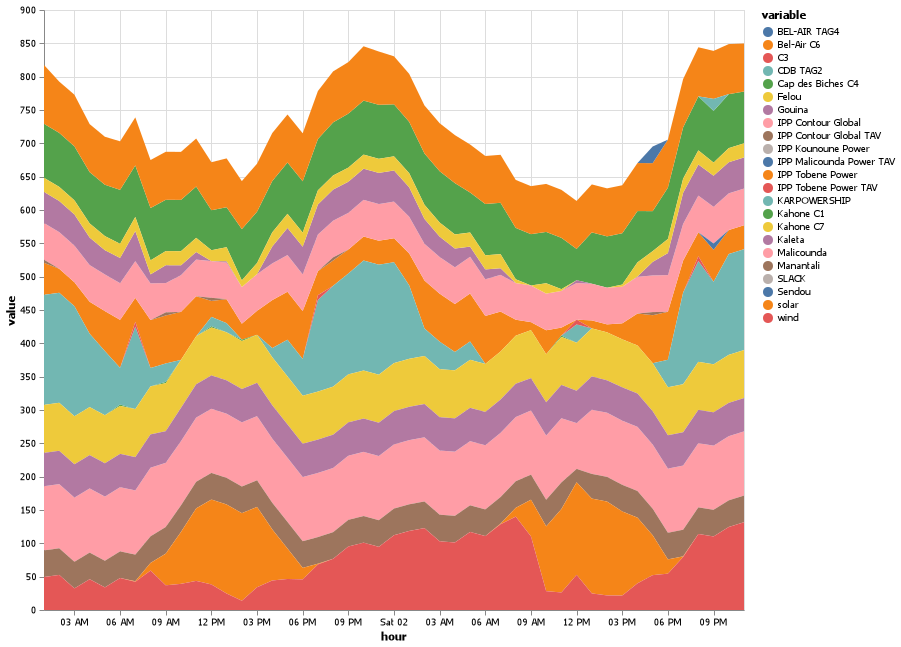

In [84]:
using VegaLite
generation |>
stack |>
@vlplot(:area, x=:hour, y={:value, stack=:zero},  width=700, height=600, color="variable:n")

In [53]:
a = get_components(ThermalStandard, system) |> collect |> filter(x -> get_name(x) == "SLACK") |> first 

SLACK (ThermalStandard):
   name: SLACK
   available: true
   status: true
   bus: BEL AIR (ACBus)
   active_power: 0.0
   reactive_power: 0.0
   rating: 10000.0
   active_power_limits: (min = 0.0, max = 10000.0)
   reactive_power_limits: nothing
   ramp_limits: (up = 10000.0, down = 10000.0)
   operation_cost: ThreePartCost
   base_power: 100.0
   time_limits: (up = 0.0, down = 0.0)
   must_run: false
   prime_mover_type: PrimeMovers.ST = 20
   fuel: ThermalFuels.RESIDUAL_FUEL_OIL = 6
   services: 0-element Vector{Service}
   time_at_status: 10000.0
   dynamic_injector: nothing
   ext: Dict{String, Any}()
   time_series_container: 
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.DEVICE_BASE = 1

In [85]:
sum(r2_df[1, 2:end])

140.00000000000404

In [69]:
r2_df

Row,datetime,Malicounda_4,C3_2,Gouina,IPP Tobene Power_2,Kahone C1_2,BEL-AIR TAG4,Malicounda_7,Cap des Biches C4_1,KARPOWERSHIP_6,Kahone C1_1,IPP Contour Global_2,IPP Contour Global_3,IPP Tobene Power_6,KARPOWERSHIP_7,IPP Tobene Power_3,IPP Tobene Power TAV_2,IPP Kounoune Power_3,Cap des Biches C4_4,KARPOWERSHIP_1,Kahone C7_5,Bel-Air C6_3,Kahone C1_4,Kahone C7_4,Malicounda_5,Bel-Air C6_6,Felou,KARPOWERSHIP_12,Bel-Air C6_1,Kahone C7_3,KARPOWERSHIP_9,Malicounda_6,IPP Contour Global_1,IPP Tobene Power_5,KARPOWERSHIP_3,Bel-Air C6_4,Cap des Biches C4_3,IPP Malicounda Power TAV,IPP Tobene Power_1,KARPOWERSHIP_2,IPP Contour Global_4,Bel-Air C6_2,IPP Kounoune Power_8,KARPOWERSHIP_5,IPP Kounoune Power_9,C3_1,Kahone C7_2,IPP Kounoune Power_1,IPP Kounoune Power_2,Kahone C7_1,Malicounda_1,KARPOWERSHIP_10,SLACK,Kahone C1_3,Manantali,Malicounda_2,Cap des Biches C4_5,Kaleta,KARPOWERSHIP_4,Bel-Air C6_5,IPP Contour Global_5,IPP Kounoune Power_7,IPP Kounoune Power_6,KARPOWERSHIP_11,IPP Kounoune Power_5,Cap des Biches C4_2,IPP Kounoune Power_4,Malicounda_3,Sendou,IPP Tobene Power_4,CDB TAG2,KARPOWERSHIP_8,Kahone C7_6,IPP Contour Global TAV_1
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2023-12-01T01:00:00,7.75,0.0,0.0,6.75,0.0,0.0,7.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.75,0.0,0.0,0.0,0.0,4.5,4.5,0.0,4.5,7.75,4.5,0.0,5.25,4.5,4.5,0.0,7.75,0.0,0.0,5.25,1.52278,0.0,0.0,6.75,5.25,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,4.5,7.75,5.25,0.0,0.0,0.0,0.0,0.0,0.0,5.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.75,0.0,6.75,0.0,0.0,4.5,0.0
2,2023-12-01T02:00:00,7.75,0.0,0.0,0.0,0.0,0.0,7.75,0.0,5.25,0.0,0.0,0.0,0.0,5.25,5.25,0.0,0.0,0.0,5.25,0.0,4.5,0.0,0.0,0.0,4.5,0.0,5.25,4.5,0.0,5.25,0.0,0.0,7.0,5.25,4.5,0.0,0.0,0.0,5.25,0.0,4.5,0.0,5.25,0.0,0.0,0.0,0.0,0.0,0.0,7.75,5.25,0.0,0.0,0.0,0.0,0.0,0.0,5.25,4.5,0.0,0.0,0.0,5.25,0.0,0.0,0.0,7.75,0.0,6.75,0.0,5.25,0.0,0.0
3,2023-12-01T03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,5.25,0.0,5.5,0.0,0.0,5.25,6.75,0.0,0.0,0.0,5.25,4.5,4.5,0.0,4.5,0.0,0.0,0.0,0.0,4.5,4.5,5.25,7.75,0.0,7.0,5.25,4.5,0.0,0.0,0.0,0.0,5.5,4.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0,4.5,4.25,5.25,0.0,0.0,0.0,0.0,0.0,0.0,5.25,4.5,2.5,0.0,0.0,5.25,0.0,0.0,0.0,0.0,0.0,6.75,0.0,0.0,4.5,0.0
4,2023-12-01T04:00:00,7.75,0.0,0.0,0.0,0.0,0.0,7.75,0.0,0.0,0.0,4.65608,0.0,0.0,4.84392,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,7.75,4.5,0.0,0.0,4.5,0.0,0.0,7.75,5.5,6.75,5.25,4.5,0.0,0.0,6.75,5.25,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.75,5.25,0.0,0.0,0.0,9.25,0.0,0.0,5.25,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.25,0.0,0.0,0.0,5.25,0.0,0.0
5,2023-12-01T05:00:00,7.75,0.0,0.0,6.75,0.0,0.0,7.75,0.0,4.25,0.0,5.5,5.5,8.0,5.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.75,0.0,0.0,0.0,0.0,0.0,5.25,0.0,5.5,6.75,0.0,4.5,0.0,0.0,8.0,0.0,5.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,5.25,0.0,0.0,0.0,0.0,2.0,0.0,5.25,4.5,5.5,0.0,0.0,0.0,0.0,0.0,0.0,7.75,0.0,6.75,0.0,0.0,4.5,0.0
6,2023-12-01T06:00:00,7.75,0.0,0.0,6.75,0.0,0.0,7.75,0.0,0.0,0.0,0.0,0.0,6.75,5.25,6.75,0.0,0.0,0.0,0.0,3.75,4.5,0.0,4.5,6.25,4.5,0.0,0.0,4.5,4.5,0.0,7.75,0.0,6.75,0.0,0.0,0.0,0.0,5.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,7.75,5.25,0.0,0.0,0.0,0.0,0.0,0.0,5.25,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,6.75,0.0,0.0,0.0,0.0
7,2023-12-01T07:00:00,7.75,0.0,0.0,6.0,0.0,0.0,7.75,0.0,5.25,0.0,0.0,0.0,6.75,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.75,0.0,0.0,5.25,4.5,0.0,5.25,0.0,5.5,0.0,5.25,4.5,0.0,0.0,0.0,0.0,5.5,4.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0,4.5,7.75,5.25,0.0,0.0,0.0,9.25,0.0,0.0,0.0,4.5,0.0,0.0,0.0,5.2

In [70]:
sum(r3s_df[1, 2:end])

100.0

In [71]:
r3ns_df

Row,datetime,Malicounda_4,C3_2,Gouina,IPP Tobene Power_2,Kahone C1_2,BEL-AIR TAG4,Malicounda_7,Cap des Biches C4_1,KARPOWERSHIP_6,Kahone C1_1,IPP Contour Global_2,IPP Contour Global_3,IPP Tobene Power_6,KARPOWERSHIP_7,IPP Tobene Power_3,IPP Tobene Power TAV_2,IPP Kounoune Power_3,Cap des Biches C4_4,KARPOWERSHIP_1,Kahone C7_5,Bel-Air C6_3,Kahone C1_4,Kahone C7_4,Malicounda_5,Bel-Air C6_6,Felou,KARPOWERSHIP_12,Bel-Air C6_1,Kahone C7_3,KARPOWERSHIP_9,Malicounda_6,IPP Contour Global_1,IPP Tobene Power_5,KARPOWERSHIP_3,Bel-Air C6_4,Cap des Biches C4_3,IPP Malicounda Power TAV,IPP Tobene Power_1,KARPOWERSHIP_2,IPP Contour Global_4,Bel-Air C6_2,IPP Kounoune Power_8,KARPOWERSHIP_5,IPP Kounoune Power_9,C3_1,Kahone C7_2,IPP Kounoune Power_1,IPP Kounoune Power_2,Kahone C7_1,Malicounda_1,KARPOWERSHIP_10,SLACK,Kahone C1_3,Manantali,Malicounda_2,Cap des Biches C4_5,Kaleta,KARPOWERSHIP_4,Bel-Air C6_5,IPP Contour Global_5,IPP Kounoune Power_7,IPP Kounoune Power_6,KARPOWERSHIP_11,IPP Kounoune Power_5,Cap des Biches C4_2,IPP Kounoune Power_4,Malicounda_3,Sendou,IPP Tobene Power_4,CDB TAG2,KARPOWERSHIP_8,Kahone C7_6,IPP Contour Global TAV_1
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2023-12-01T01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-12-01T02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-12-01T03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-12-01T04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2023-12-01T05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2023-12-01T06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2023-12-01T07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2023-12-01T08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [72]:
sum(pg_df[1, 2:end])

768.027218536888

In [73]:
pg_df

Row,datetime,Malicounda_4,C3_2,Gouina,IPP Tobene Power_2,Kahone C1_2,BEL-AIR TAG4,Malicounda_7,Cap des Biches C4_1,KARPOWERSHIP_6,Kahone C1_1,IPP Contour Global_2,IPP Contour Global_3,IPP Tobene Power_6,KARPOWERSHIP_7,IPP Tobene Power_3,IPP Tobene Power TAV_2,IPP Kounoune Power_3,Cap des Biches C4_4,KARPOWERSHIP_1,Kahone C7_5,Bel-Air C6_3,Kahone C1_4,Kahone C7_4,Malicounda_5,Bel-Air C6_6,Felou,KARPOWERSHIP_12,Bel-Air C6_1,Kahone C7_3,KARPOWERSHIP_9,Malicounda_6,IPP Contour Global_1,IPP Tobene Power_5,KARPOWERSHIP_3,Bel-Air C6_4,Cap des Biches C4_3,IPP Malicounda Power TAV,IPP Tobene Power_1,KARPOWERSHIP_2,IPP Contour Global_4,Bel-Air C6_2,IPP Kounoune Power_8,KARPOWERSHIP_5,IPP Kounoune Power_9,C3_1,Kahone C7_2,IPP Kounoune Power_1,IPP Kounoune Power_2,Kahone C7_1,Malicounda_1,KARPOWERSHIP_10,SLACK,Kahone C1_3,Manantali,Malicounda_2,Cap des Biches C4_5,Kaleta,KARPOWERSHIP_4,Bel-Air C6_5,IPP Contour Global_5,IPP Kounoune Power_7,IPP Kounoune Power_6,KARPOWERSHIP_11,IPP Kounoune Power_5,Cap des Biches C4_2,IPP Kounoune Power_4,Malicounda_3,Sendou,IPP Tobene Power_4,CDB TAG2,KARPOWERSHIP_8,Kahone C7_6,IPP Contour Global TAV_1
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2023-12-01T01:00:00,13.75,0.0,46.7,12.0,0.0,0.0,13.75,17.0,13.75,0.0,11.0,11.0,0.0,13.75,12.0,0.0,0.0,15.0,13.75,12.0,13.5,0.0,12.0,13.75,13.5,21.15,13.75,13.5,12.0,13.75,13.75,11.0,0.0,13.75,16.4772,17.0,0.0,12.0,13.75,11.0,18.0,0.0,13.75,0.0,0.0,12.0,0.0,0.0,12.0,13.75,13.75,0.0,0.0,39.95,13.75,15.0,50.0,13.75,18.0,11.0,0.0,0.0,13.75,0.0,17.0,0.0,13.75,0.0,12.0,0.0,13.75,12.0,0.0
2,2023-12-01T02:00:00,13.75,0.0,46.7,0.0,0.0,0.0,13.75,17.0,13.75,0.0,11.0,11.0,0.0,13.75,12.0,0.0,0.0,15.0,13.75,12.0,12.4078,0.0,12.0,13.75,13.5,21.15,13.75,12.0,12.0,13.75,13.75,11.0,12.0,13.75,13.5,17.0,0.0,0.0,13.75,11.0,13.5,0.0,13.75,0.0,0.0,12.0,0.0,0.0,12.0,13.75,13.75,0.0,0.0,39.95,13.75,15.0,50.0,13.75,12.0,11.0,0.0,0.0,13.75,0.0,17.0,0.0,13.75,0.0,12.0,0.0,13.75,12.0,0.0
3,2023-12-01T03:00:00,13.75,0.0,46.7,0.0,0.0,0.0,13.75,17.0,13.75,0.0,11.0,11.0,0.0,13.75,12.0,0.0,0.0,15.0,13.75,12.0,13.5,0.0,12.0,13.75,12.0,21.15,13.75,12.941,12.0,13.75,13.75,11.0,12.0,13.75,12.0,17.0,0.0,0.0,13.75,11.0,13.5,0.0,13.75,0.0,0.0,12.0,0.0,0.0,12.0,13.75,13.75,0.0,0.0,39.95,13.75,15.0,50.0,13.75,13.5,11.0,0.0,0.0,13.75,0.0,17.0,0.0,13.75,0.0,12.0,0.0,13.75,12.0,0.0
4,2023-12-01T04:00:00,13.75,0.0,41.2939,0.0,0.0,0.0,13.75,17.0,13.75,0.0,11.0,11.0,0.0,13.75,12.0,0.0,0.0,13.0,0.0,12.0,12.0,0.0,12.0,13.75,12.0,21.15,0.0,12.0,12.0,13.75,13.75,11.0,12.0,13.75,12.0,17.0,0.0,12.0,13.75,11.0,12.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,12.0,13.75,13.75,0.0,0.0,39.95,13.75,13.0,50.0,13.75,12.0,11.0,0.0,0.0,0.0,0.0,17.0,0.0,13.75,0.0,12.0,0.0,13.75,12.0,0.0
5,2023-12-01T05:00:00,13.75,0.0,40.6691,12.0,0.0,0.0,13.75,17.0,13.75,0.0,11.0,11.0,12.0,13.75,0.0,0.0,0.0,13.0,0.0,12.0,12.0,0.0,12.0,13.75,12.0,21.15,0.0,12.0,12.0,13.75,13.75,11.0,12.0,0.0,12.0,17.0,9.44,12.0,13.75,11.0,12.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,12.0,13.75,13.75,0.0,0.0,39.95,13.75,13.0,50.0,13.75,12.0,11.0,0.0,0.0,0.0,0.0,17.0,0.0,13.75,0.0,12.0,0.0,0.0,12.0,0.0
6,2023-12-01T06:00:00,13.75,0.0,35.2281,12.0,0.0,0.0,13.75,17.0,0.0,0.0,11.0,11.0,12.0,13.75,12.0,0.0,0.0,13.0,0.0,12.0,12.0,0.0,12.0,13.75,12.0,21.15,0.0,12.0,12.0,0.0,13.75,11.0,12.0,0.0,12.0,17.0,9.44,12.0,13.75,11.0,12.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,12.0,13.75,13.75,0.0,0.0,39.95,13.75,13.0,50.0,13.75,12.0,11.0,0.0,0.0,0.0,0.0,17.0,0.0,13.75,0.0

In [74]:
Ɣ2_df

Row,datetime,Ɣ2
,DateTime,Float64
1,2023-12-01T01:00:00,2.22722
2,2023-12-01T02:00:00,0.0
3,2023-12-01T03:00:00,0.0
4,2023-12-01T04:00:00,0.0
5,2023-12-01T05:00:00,0.0
6,2023-12-01T06:00:00,0.0
7,2023-12-01T07:00:00,0.0
8,2023-12-01T08:00:00,0.0
9,2023-12-01T09:00:00,0.0


In [75]:
maximum(Ɣ3_df[!, Symbol("Ɣ3")])

3.2793915488960668

In [107]:
result.pg["Malicounda_4", :]

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:47
And data, a 47-element Vector{Float64}:
 13.75
 23.0
 14.0
 13.75
 23.0
 18.0
 13.75
 13.75
 20.5
 13.94822346075307
 13.75
 13.75
 13.75
  ⋮
  0.0
  0.0
  0.0
  0.0
 13.75
 13.75
 13.75
 23.0
 13.75
 13.75
 23.0
 13.75